<a href="https://colab.research.google.com/github/meharshmenon/Speech-to-ASL/blob/main/Copy_of_Yet_another_copy_of_projNUS101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d awsaf49/ljspeech-sr16k-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/ljspeech-sr16k-dataset
License(s): unknown
 99% 2.17G/2.18G [00:37<00:00, 33.2MB/s]
100% 2.18G/2.18G [00:37<00:00, 62.8MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/ljspeech-sr16k-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('ljspeech_sr16k_dataset')

In [ ]:
!pip install jiwer
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
import os
import warnings
import random

In [ ]:
current_directory = os.getcwd()
print("Current Directory:", current_directory)


parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))


os.chdir(parent_directory)


updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Current Directory: /content
Updated Directory: /


In [ ]:
wavs_path = "/content/ljspeech_sr16k_dataset/wavs"

In [ ]:
df = pd.read_csv('/content/ljspeech_sr16k_dataset/metadata.csv')

df_last_5000 = df.tail(8000)


df_last_5000.to_csv('/content/ljspeech_sr16k_dataset/metadata_last_5000.csv', index=False)
df = pd.read_csv('/content/ljspeech_sr16k_dataset/metadata_last_5000.csv')

metadata_df = df[["id","sentence"]]
metadata_df.head(5)

,id,sentence
0,LJ017-0246,"the mutineers took command of the ship, put he..."
1,LJ017-0247,The rest of the crew were also permitted to em...
2,LJ017-0248,while the other two were left to go down in th...
3,LJ017-0249,The boats reached the shore on the 4th October...
4,LJ017-0250,"from Peru bound to Bordeaux, which had founder..."


In [ ]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the testing set: {len(df_val)}")

Size of the training set: 7200
Size of the testing set: 800


In [ ]:
import tensorflow as tf
from tensorflow import keras

characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]

char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)


print(f"The vocabulary is: {char_to_num.get_vocabulary()} (size={char_to_num.vocabulary_size()})")


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size=31)


In [ ]:

frame_length = 256

frame_step = 160

fft_length = 384


def encode_single_sample(wav_file, label):
    file_path = wavs_path + "/" + wav_file + ".wav"
    print(f"Processing file: {file_path}")
    file = tf.io.read_file(file_path)

    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    audio = tf.debugging.check_numerics(audio, "audio contains NaNs or Infs")

    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.debugging.check_numerics(spectrogram, "spectrogram contains NaNs or Infs")
    spectrogram = tf.math.pow(spectrogram, 0.5)

    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-6)

    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    label = tf.debugging.check_numerics(tf.cast(label, tf.float32), "label contains NaNs or Infs")

    return spectrogram, label

In [ ]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["id"]), list(df_train["sentence"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["id"]), list(df_val["sentence"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Processing file: Tensor("add_1:0", shape=(), dtype=string)
Processing file: Tensor("add_1:0", shape=(), dtype=string)


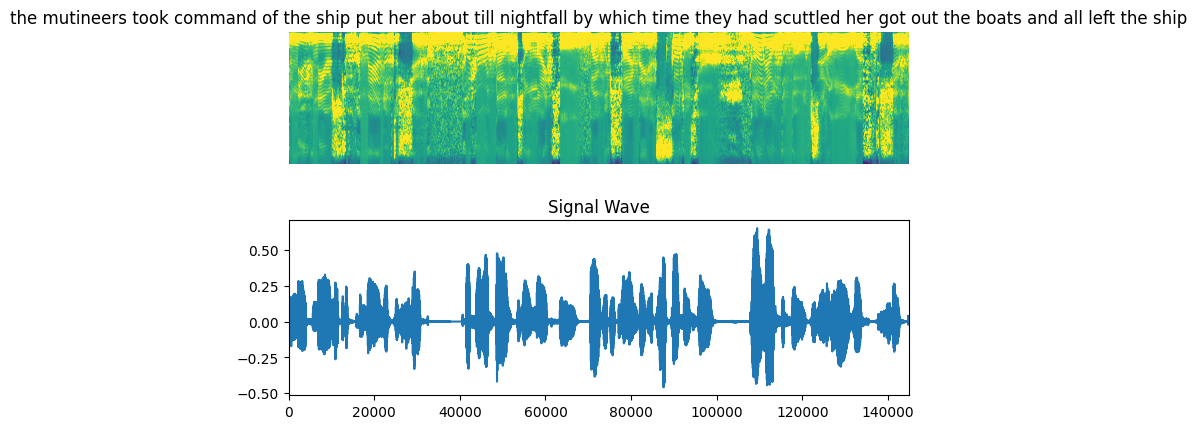

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]

    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")

    file = tf.io.read_file(wavs_path +"/"+ list(df_train["id"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [ ]:
def CTCLoss(y_true, y_pred):

    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
from tensorflow.keras import layers, Model, optimizers

def build_model(input_dim, output_dim, rnn_layers=3, rnn_units=256):


    input_spectrogram = layers.Input((None, input_dim), name="input")

    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)

    x = layers.Conv2D(
        filters=16,
        kernel_size=[11, 21],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    x = layers.Conv2D(
        filters=16,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    for i in range(1, rnn_layers + 1):
        recurrent = layers.LSTM(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            name=f"lstm_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.3)(x)

    x = layers.Dense(units=rnn_units * 2, name="dense_1_a")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.3)(x)

    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    model = Model(input_spectrogram, output, name="NUSPROJBYMAYANK")

    opt = optimizers.Adam(learning_rate=1e-4)

    model.compile(optimizer=opt, loss=CTCLoss)
    return model


fft_length = 384

model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=256,
)
model.summary(line_length=110)


Model: "NUSPROJBYMAYANK"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 16)                        3696             
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 16)                  

In [ ]:

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]

    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text



class CallbackEval(keras.callbacks.Callback):


    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
checkpoint_filepath1 = '/content/drive/MyDrive/epoch-57.keras'
model.load_weights(checkpoint_filepath1)

In [ ]:
from tensorflow.keras import layers, Model, optimizers, callbacks


checkpoint_filepath2 = '/content/drive/MyDrive/checkpoints/epoch-70.keras'


model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath2,
    save_weights_only=True,
    save_freq='epoch',
    verbose=1
)

validation_callback = CallbackEval(validation_dataset)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    initial_epoch=55,
    epochs=70,
    callbacks=[validation_callback, model_checkpoint_callback],
)


model.save("/content/drive/MyDrive/my_Projmodel105.keras")

Epoch 56/70
1/1 [==============================] - 0s 149ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3597
----------------------------------------------------------------------------------------------------
Target    : the wholehearted support of these local authorities was indispensable to the service in carrying out its duties
Prediction: the whole harted support af fese local uthorities was indispensible to the service in caring out etxs duties
----------------------------------------------------------------------------------------------------
Target    : nine agents who were off duty went to the nearby fort worth press club at midnight or slightly thereafter expecting to obtain food
Prediction: nin agents who were of duty went to the near by fort worth preisclp at madnight or slightly therafter expecting to obtaine fod
---------------------------------------------------------------------------------

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, model_checkpoint_callback],
)

model.save("/content/drive/MyDrive/my_Projmodel105.keras")

Epoch 1/70
1/1 [==============================] - 0s 151ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : while the secret service representatives in dallas
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : that agents of the fbi in dallas did not consider oswald's presence in the texas school book depository building
Prediction: 
----------------------------------------------------------------------------------------------------

Epoch 1: saving model to /content/drive/MyDrive/checkpoints/epoch-57.keras
225/225 [==============================] - 538s 2s/step - loss: 330.2953 - val_loss: 334.5586
Epoch 2/70
1/1 [==============================] - 0s 148ms/step
------------------------------------------------------------

In [ ]:
model.save("/content/drive/MyDrive/my_Projmodel105.keras")

In [ ]:
model.save("/content/drive/MyDrive/speech_recognition_modelLSTM.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
